# 유방암

## 속성 정보(data):

1) ID 숫자 2) 진단 (M = 악성, B = 양성) 3-32)

각 세포핵의 10개의 실제 값 형상이 존재 :

a) 반지름 (mean of distances from center to points on the perimeter) 
b) 질감 (standard deviation of gray-scale values) 
c) 면적 
d) 지역 
e) 평탄도 (local variation in radius lengths) 
f) 소형화 (perimeter^2 / area - 1.0) 
g) 오목함 (severity of concave portions of the contour) 
h) 오목한 지점 (number of concave portions of the contour) 
i) 균형 
j) 기하학적 치수 ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

모든 형상 값은 4자리 숫자로 존재

속성 값 누락 없음

Class distribution: 357 (양성)benign, 212 (음성)malignant

참고자료: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2 

In [0]:
# 악성인지 비성인지 구별하기로 한다. diagnosis(M = malignant, B = benign) 숫자데이터로 판단할 것입니다. feature에 대한 내용들이 아래와 같이 있습니다.
# 참고링크: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2 
import numpy as np
import pandas as pd

# 그래프를 그려보자
import matplotlib.pyplot as plt
import seaborn as sns

# 사이킷런의 모듈을 사용하고,학습 데이터와 테스트 데이터를 분리
# 참고자료: https://scikit-learn.org/stable/modules/classes.html
from sklearn.model_selection import train_test_split

# cross validation 구현시 사용할꺼다.
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics

# 서프벡터머신, 로지스틱 회귀분석, 렌덤포레스트, k-최근접 이웃분류, 의사결정나무
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [0]:
# 데이터 판다스로 불러오기
cancer_data = pd.read_csv('breast_cancer.csv')
cancer_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [0]:
# 데이터의 타입과 null 개수를 출력한다, 이것은 데이터를 가공하기 위해서 한다.
cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [0]:
# 데이터를 정제하는 과정에서 id, Unnamed를 drop함으로써 없애준다고 생각하면 된다. id는 정보가 필요없고, unamed는 널이 아닌게 0개라서
cancer_data.drop(['id', 'Unnamed: 32'], axis = 1, inplace = True)

In [0]:
# benign: 양성(0), malignant 악성(1) 숫자로 바꿔주기 위해서 대체를 시켜준다. map 사용
cancer_data['diagnosis'] = cancer_data['diagnosis'].map({'B': 0, 'M': 1})
cancer_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [0]:
# describe()는 데이터의 개요를 살펴보자.
cancer_data.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


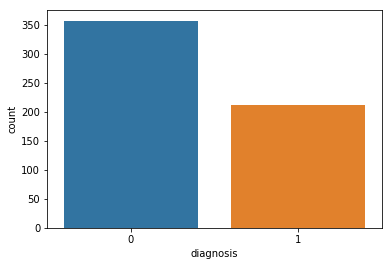

In [0]:
# sns,countplot()은 시본(seaborn) 패키지로 사용하면 박스 그래프를 시각화 할 수 있다. 여러가지 그래프를 가져온다.
# 참고자료: https://seaborn.pydata.org/api.html
# diagnosis의 모양이 어떻게 되는지 확인하기 위해 사용해보자.

sns.countplot(cancer_data['diagnosis'])

# 0(양성), 1(음성) 다음과 같이 그림처럼 볼 수 있다.

In [0]:
# split train and test
# diagnosis는 x에 있으면 안된다. 즉 y로 예측하기 위해서 x축에 있으면 안되니까 drop해준다.

train, test = train_test_split(cancer_data, test_size = 0.2, random_state = 2019)

x_train = train.drop(['diagnosis'], axis = 1)
y_train = train.diagnosis

x_test = test.drop(['diagnosis'], axis = 1)
y_test = test.diagnosis

# len을 통해 몇개씩 있는지 길이를 보는 것이다.
print(len(train), len(test))

# 455개의 트레인, 144개의 테스트에 찍어볼 것이다.

455 114


In [0]:
# svm 서포트벡터머신: 
# fit를 사용하면 학습이 된다.
model_svm = svm.SVC(gamma = 'scale')
model_svm.fit(x_train, y_train)

y_pred = model_svm.predict(x_test)

print('SVM: %.2f' % (metrics.accuracy_score(y_pred, y_test) * 100))

# 91.23퍼센트의 정확도가 나온다.

SVM: 91.23


In [0]:
# decisionTreeclassifier
model_dt = DecisionTreeClassifier()
model_dt.fit(x_train, y_train)

y_pred = model_dt.predict(x_test)

print('DecisionTreeClassifier: %.2f' % (metrics.accuracy_score(y_pred, y_test) * 100))

# 89.47퍼센트의 정확도가 나온댜.  


DecisionTreeClassifier: 89.47


In [0]:
# KNeighborsClassifier
model_kn = KNeighborsClassifier()
model_kn.fit(x_train, y_train)

y_pred = model_kn.predict(x_test)

print('KNeighborsClassifier: %.2f' % (metrics.accuracy_score(y_pred, y_test) * 100))

# 92.98퍼센트의 정확도가 나온댜.  

KNeighborsClassifier: 92.98


In [0]:
# LogisticRegression solver안의 파라미터 수정하면서 설정하여 바꾸기
model_lg = LogisticRegression(solver = 'lbfgs', max_iter = 2000)
model_lg.fit(x_train, y_train)

y_pred = model_lg.predict(x_test)

print('LogisticRegression: %.2f' % (metrics.accuracy_score(y_pred, y_test) * 100))

# 94.74퍼센트의 정확도가 나온다. 


LogisticRegression: 94.74


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [0]:
# RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators = 50)
model_rf.fit(x_train, y_train)

y_pred = model_rf.predict(x_test)

print('RandomForestClassifier: %.2f' % (metrics.accuracy_score(y_pred, y_test) * 100))

# 95.61퍼센트의 정확도가 나온다. 


RandomForestClassifier: 95.61


In [0]:
# compute feature importances 판다스의 Series를 사용하여 내림차순(ascending = False)으로 정렬시킨다.
features = pd.Series(model_rf.feature_importances_, index = x_train.columns).sort_values(ascending = False)

print(features)

# 퓨터들을 중요도들이 위로 갈수록 영향력이 높은 것이다. 제일 정확도가 높았던 렌덤포레스트의 모델을 사용하여 학습시키고 내림차순으로 값을 정렬시킨다.
# 상위 5개를 가지고 모델을 다시 만들어본다.

perimeter_worst            0.150672
concave points_worst       0.121895
radius_worst               0.121851
concave points_mean        0.107668
area_worst                 0.091961
area_mean                  0.069103
perimeter_mean             0.053900
radius_mean                0.038887
area_se                    0.036856
concavity_mean             0.035637
concavity_worst            0.028464
compactness_worst          0.018355
radius_se                  0.016628
texture_worst              0.011684
symmetry_worst             0.010936
compactness_mean           0.010916
perimeter_se               0.010717
smoothness_worst           0.009610
texture_mean               0.008994
fractal_dimension_worst    0.007343
concave points_se          0.005935
compactness_se             0.004808
smoothness_mean            0.004707
texture_se                 0.004110
concavity_se               0.003783
smoothness_se              0.003502
fractal_dimension_mean     0.002960
symmetry_se                0

In [0]:
# extract top5 features 상위 5개 뽑아보기
top_5_features = features.keys()[:5]

print(top_5_features)

Index(['perimeter_worst', 'concave points_worst', 'radius_worst',
       'concave points_mean', 'area_worst'],
      dtype='object')


In [0]:
# top5로 서포트 벡터머신으로 돌려보기
model_svm_5 = svm.SVC(gamma = 'scale')
model_svm_5.fit(x_train[top_5_features], y_train)

y_pred = model_svm_5.predict(x_test[top_5_features])

print('SVM(TOP 5): %.2f' % (metrics.accuracy_score(y_pred, y_test) * 100))

# 정확도 퍼센트가 그대로 나왔다. 그런데 이 문제는 아까 데이터셋 split할까 random_state의 값에 따라 정확도가 상승하거나 감소하는 것 같다.


SVM(TOP 5): 91.23


In [0]:
# top5로 렌덤포레스트 돌려보기
model_rf_5 = RandomForestClassifier(n_estimators = 50)
model_rf_5.fit(x_train[top_5_features], y_train)

y_pred = model_rf_5.predict(x_test[top_5_features])

print('RandomForestClassifier(TOP 5): %.2f' % (metrics.accuracy_score(y_pred, y_test) * 100))

# 92.11퍼센트의 정확도가 나온다. 여기서는 감소를 해버렸다.

RandomForestClassifier(TOP 5): 92.11


In [0]:
# cross valibation 교차검증: 데이터셋이 적을 때 효과적인 방법이다.
# 참고 자료: https://www.google.com/search?q=cross+validation&source=lnms&tbm=isch&sa=X&ved=0ahUKEwijr_7I0OjjAhW6xosBHbv7AKkQ_AUIEygD&biw=1414&bih=745#imgrc=4HamcWDnKeYOBM:


model_svm_5 = svm.SVC(gamma = 'scale')

# 5개의 스플릿된 데이터로
cv = KFold(n_splits = 5, random_state = 2019)

# accs에 []로 append를 통해 나타낼 것임
accs = []

# for문을 돌면서 train index에 포함된 데이터만 뽑아내고 top_5_features로 필터링을 하고 x_train에 저장하고 y_train도 마찬가지로
# test데이터도 마찬가지로 한다.
for train_index, test_index in cv.split(cancer_data[top_5_features]):
  x_train = cancer_data.iloc[train_index][top_5_features]
  y_train = cancer_data.iloc[train_index].diagnosis
  
  x_test = cancer_data.iloc[test_index][top_5_features]
  y_test = cancer_data.iloc[test_index].diagnosis
  
  
  model_svm_5.fit(x_train, y_train)
  
  y_pred = model_svm_5.predict(x_test)
  
  accs.append(metrics.accuracy_score(y_test, y_pred))

  
  print(accs)
  

[0.7807017543859649]
[0.7807017543859649, 0.8947368421052632]
[0.7807017543859649, 0.8947368421052632, 0.9736842105263158]
[0.7807017543859649, 0.8947368421052632, 0.9736842105263158, 0.9298245614035088]
[0.7807017543859649, 0.8947368421052632, 0.9736842105263158, 0.9298245614035088, 0.9380530973451328]


In [0]:
# cross validation의 simple하게 나타내기: 위에 코드를 짧게

model_svm_5 = svm.SVC(gamma = 'scale')

cv = KFold(n_splits = 5, random_state = 2019)

accs = cross_val_score(model_svm_5, cancer_data[top_5_features], cancer_data.diagnosis, cv = cv) # kfold를 정의해주기

print(accs)

[0.78070175 0.89473684 0.97368421 0.92982456 0.9380531 ]


In [0]:
# 
models = {
    'SVM': svm.SVC(gamma = 'scale'),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(solver = 'lbfgs', max_iter = 2000),
    'RandomForestClassifier': RandomForestClassifier(n_estimators = 100)
}

cv = KFold(n_splits = 5, random_state = 2019)

for name, model in models.items():
  scores = cross_val_score(model, cancer_data[top_5_features], cancer_data.diagnosis, cv = cv)
  
  
  print('%s: %.2f%%' % (name, np.mean(scores)* 100))

SVM: 90.34%
DecisionTreeClassifier: 91.21%
KNeighborsClassifier: 88.40%
LogisticRegression: 90.69%
RandomForestClassifier: 93.15%


In [0]:
# normalize dataset, 사이킷런의 minmaxscaler
# 참고자료: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))

scaled_cancer_data = scaler.fit_transform(cancer_data[top_5_features])

models = {
    'SVM': svm.SVC(gamma = 'scale'),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(solver = 'lbfgs', max_iter = 2000),
    'RandomForestClassifier': RandomForestClassifier(n_estimators = 100)
}


cv = KFold(n_splits = 5, random_state = 2019)
for name, model in models.items():
  scores = cross_val_score(model, cancer_data[top_5_features], cancer_data.diagnosis, cv = cv)
  
  print('%s: %.2f%%' % (name, np.mean(scores)* 100))

SVM: 90.34%
DecisionTreeClassifier: 91.38%
KNeighborsClassifier: 88.40%
LogisticRegression: 90.69%
RandomForestClassifier: 93.33%
